## Camera Calibration Matrix for Front Facing Semantic Camera

This notebook constructs the calibration matrix for front facing semantic camera. Since the camera in Carla is ideal and without installation errors, these matrices can be manually set.

In [1]:
import numpy as np
import cv2
import yaml

import numpy as np
from math import tan
import cv2
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

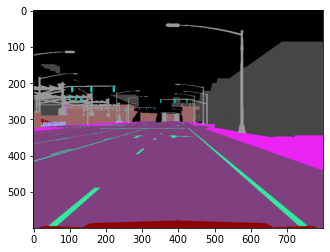

In [2]:
# Prepare data
config_path = r"../config/town03.yaml"
with open(config_path, 'r') as config_file:
    config_args = yaml.safe_load(config_file)
# FOV in deg
fov = float(config_args['sensor']['semantic_image']['fov'])

# Image resolution
res_h = int(config_args['sensor']['semantic_image']['res_h'])
res_v = int(config_args['sensor']['semantic_image']['res_v'])

# Image for calibration
calib_img = cv2.imread('./calib_images/ss_image.png')
plt.imshow(calib_img)

In [3]:
# Calibration matrix
# Intrinsic calibration matrix of semantic camera
# FOV (in rad)
fov_rad = fov * np.pi / 180  # 60 degrees
# Focal length of semantic camera (in pixel)
f = res_h/2 / tan(fov_rad/2)

# Intrinsic calibration matrix
K = np.array([[f, 0, res_h/2],
              [0, f, res_v/2],
              [0, 0, 1]])

# Extrinsic calibration matrix
# Compute relative translation of camera wrt front bumper
dist_cam_to_fbumper = (config_args['ego_veh']['raxle_to_fbumper'] 
    - config_args['sensor']['semantic_image']['pos_x'] 
    + config_args['ego_veh']['raxle_to_cg'])
camera_height = config_args['sensor']['semantic_image']['pos_z']
# Camera's origin (principal point) wrt the reference frame, which is the front bumper center in the x-y plane in this case
x0 = np.array([[-dist_cam_to_fbumper, 0, camera_height]]).T

# Rotation matrix describing the orientation of reference frame wrt the camera frame
# This is trival enough to set it manually in this project. Some automation might be needed in the future.
R = Rotation.from_euler('zyx', [90, 0, 90], degrees=True).as_matrix()

P = K @ R @ np.concatenate((np.eye(3), -x0), axis=1)

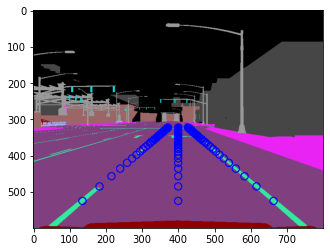

In [4]:
# World to image projection
calib_image_copy = calib_img.copy()
for x in range(40):
    for y in [-1.75, 0, 1.75]:
        x_world = np.array([[x, y, 0, 1]]).T
        x_img = P @ x_world
        x_img /= x_img[-1]
        calib_image_copy = cv2.circle(
            calib_image_copy, tuple(x_img[0:2]), 10, color=[0, 0, 255], thickness=2)
plt.imshow(calib_image_copy)

In [5]:
# This matrix is useful for projecting 2D pixels into the 3D world with z known
# Pole detection will use it.
K_inv = np.linalg.inv(K)
H = R.T @ K_inv

In [6]:
np.savez('calib_data', K=K, R=R, x0=x0, H=H)